# TomoTools Demo
* TomoTools is a Hyperspy-based package designed for manipulating and reconstructing electron tomography data
* Depends on several external libraries beyond Hyperspy
    * OpenCV: spatial registration
    * TomoPy: reconstruction
    * Astra Toolbox: GPU-based reconstruction

### Installation
* Install external packages:
    * conda install -c conda-forge hyperspy
    * conda install -c conda-forge opencv
    * conda install -c astra-toolbox astra-toolbox
    * conda install -c conda-forge tomopy
    
    
* Install TomoTools via pip:
    * pip install git+https://gitlab.com/aaherzing/tomotools.git

In [1]:
%matplotlib notebook
import tomotools.api as tomotools
import matplotlib.pylab as plt

### Read data from HDF5 file
- Converts to TomoStack, a sub-class of HyperSpy's Signal2D
* In this case, the tilts angles have to be manually supplied

<IPython.core.display.Javascript object>


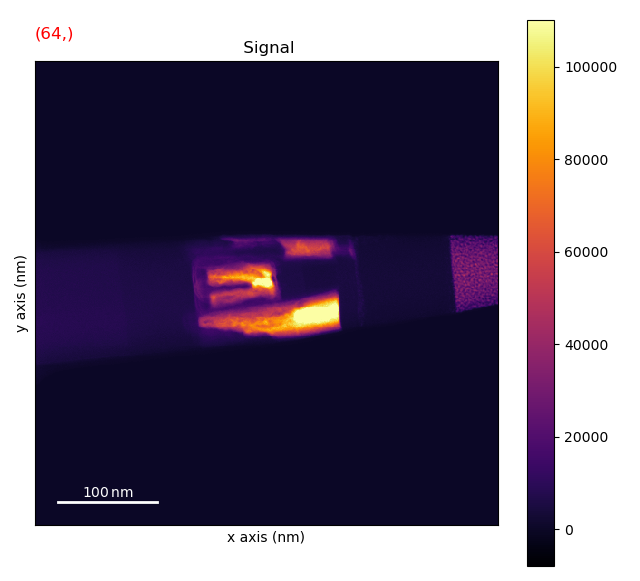

In [2]:
haadf = tomotools.load('data/TomoTools_HAADF.hdf5')
haadf.plot(navigator='slider',cmap='inferno',vmin=-8000,vmax=110000)

### Spatially register the image stack 
- Using enhanced correlation coefficient algorithm as implemented in OpenCV

100%|██████████| 39/39 [00:00<00:00, 54.45it/s]


<IPython.core.display.Javascript object>


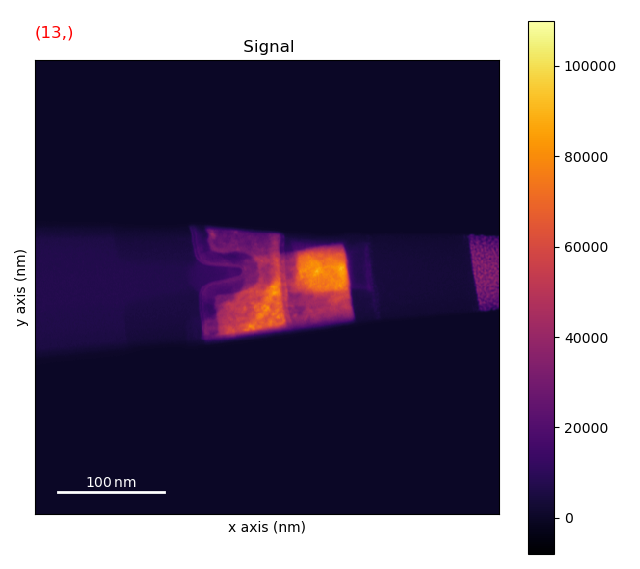

In [3]:
reg = haadf.stack_register('ECC', crop=True, show_progressbar=True)
reg.plot(navigator='slider',cmap='inferno',vmin=-8000,vmax=110000)

### Align the tilt axis and lateral shift
- Minimizes reconstruction artifacts
- Based on tracking the center of mass (CoM) of the needle
- User must specify three locations in stack from which to perform the fitting
- It is best to choose locations that are in a single phase slice of the data

<IPython.core.display.Javascript object>


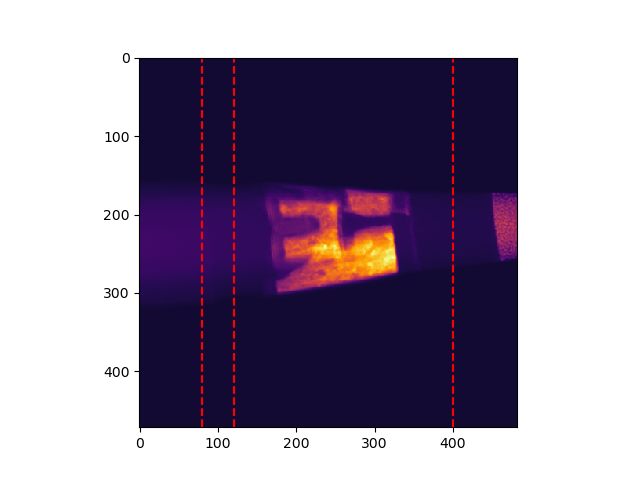

In [4]:
fig,ax = plt.subplots(1)
ax.imshow(reg.data[35,:,:], cmap='inferno', vmin=-8000,vmax=80000)
ax.axvline(80,color='red',linestyle='--')
ax.axvline(120,color='red',linestyle='--')
ax.axvline(400,color='red',linestyle='--')


Correcting tilt axis....
Iteration #1
Calculated tilt correction is: -4.46574902082
Calculated shift value is: -22.8950001073
Iteration #2
Calculated tilt correction is: -0.186989059707
Calculated shift value is: 16.7895224215
Iteration #3
Calculated tilt correction is: -0.0567220108867
Calculated shift value is: 0.71491431474

Tilt axis alignment complete


<IPython.core.display.Javascript object>


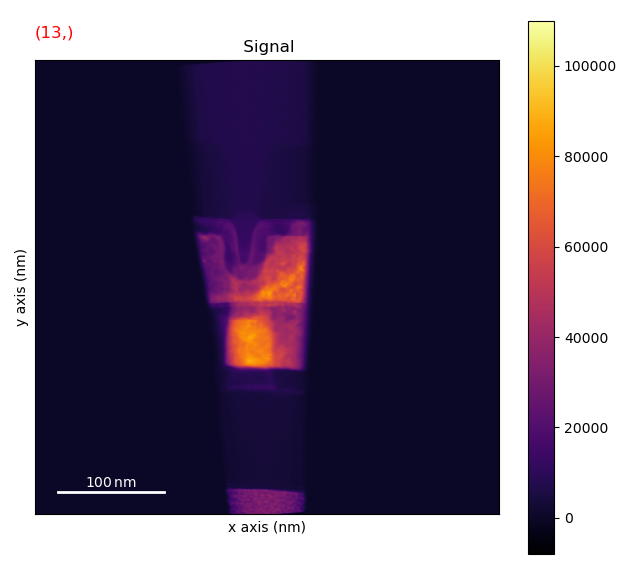

In [6]:
ali = reg.tilt_align('CoM',locs=[80,120,400])
ali.plot(navigator='slider',cmap='inferno',vmin=-8000,vmax=110000)

## Test aligment and reconstruction parameters
* Reconstructs three slices only to provide quick feedback about alignment and reconstruction parameters
* Can also be used for manually performing coarse alignment of X-shift and tilt axis rotation

Reconstruction complete


<IPython.core.display.Javascript object>


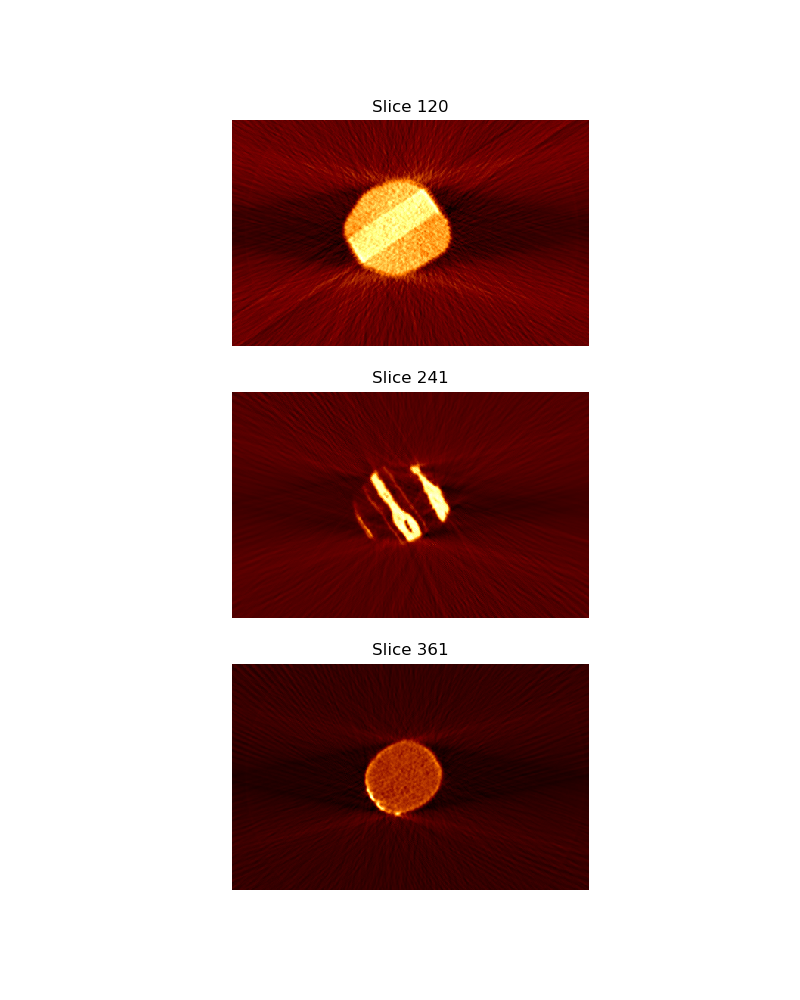

In [7]:
ali.test_align(thickness = 300)

## Reconstruct using weighted-backprojection
* Full dataset reconstructed
* Data can be vizualized in the X-Z orientation
* Visualization in other orientations can be achieved using the `swap_axes` Hyperspy method


### Reconstruct subset of full stack for speed

In [8]:
recWBP = ali.isig[:,150:350].reconstruct(method='FBP',thickness=300)

Reconstruction complete


<IPython.core.display.Javascript object>


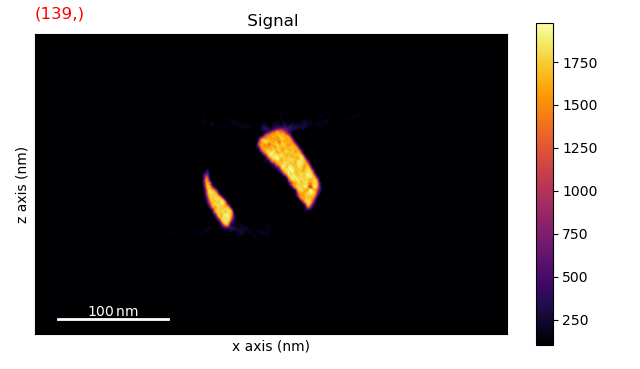

In [9]:
recWBP.plot(navigator='slider',cmap='inferno',vmin=100)

<IPython.core.display.Javascript object>


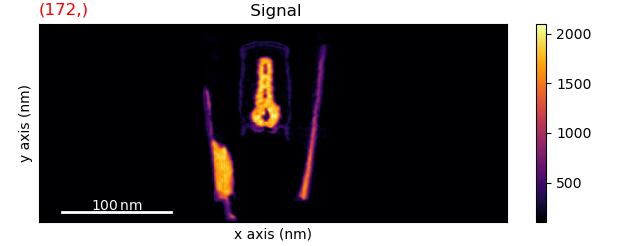

In [10]:
recWBP.swap_axes(0,2).plot(navigator='slider',cmap='inferno',vmin=100)

### Reconstruct full stack

In [11]:
recWBP_full = ali.reconstruct(method='FBP',thickness=300)

Reconstruction complete


<IPython.core.display.Javascript object>


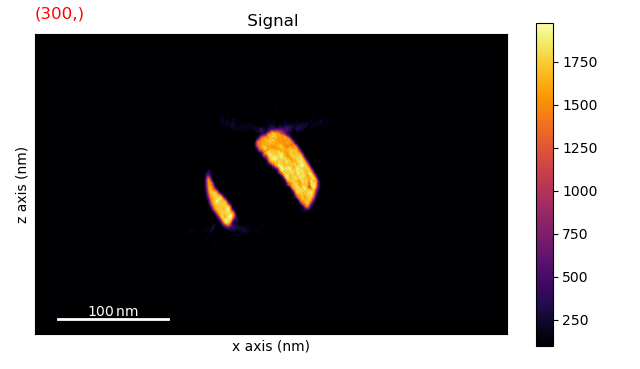

In [12]:
recWBP_full.plot(navigator='slider',cmap='inferno',vmin=100)

<IPython.core.display.Javascript object>


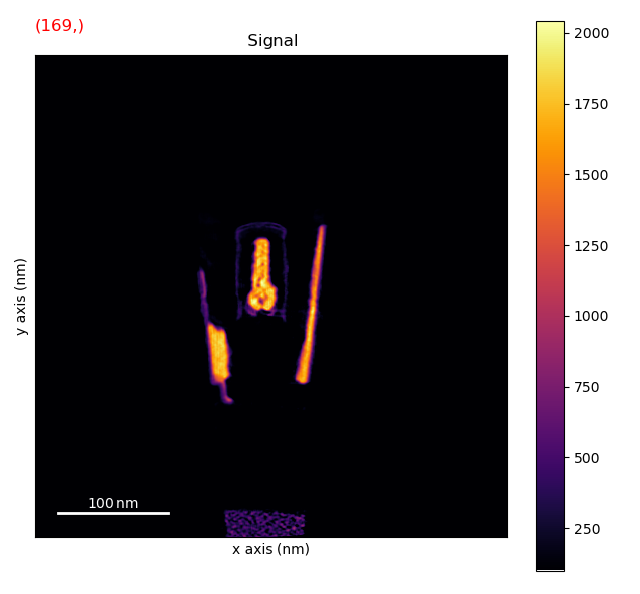

In [13]:
recWBP_full.swap_axes(0,2).plot(navigator='slider',cmap='inferno',vmin=100)

## Reconstruct the data using simulataneous iterative reconstruction technique (SIRT). 
- In this case, only ten slices from the middle of the stack are reconstructed to speed things up.
- 150 iterations
- Apply a positivity constraint

In [14]:
recSIRT150 = ali.isig[:,250:260].reconstruct(method='SIRT',thickness=300,iterations=150,constrain=True)

Reconstruction complete


<IPython.core.display.Javascript object>


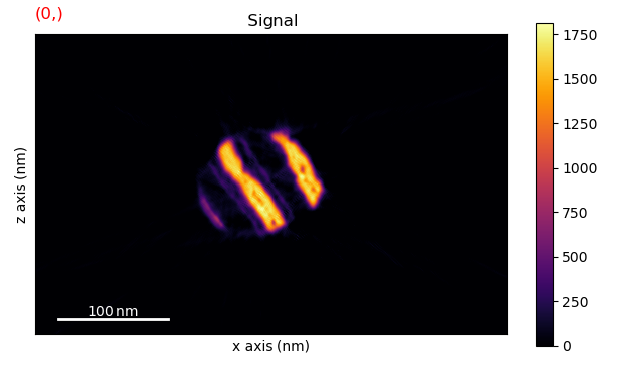

In [14]:
recSIRT150.plot(navigator='slider', cmap='inferno')

## Reconstruct the entire dataset SIRT
- 150 iterations
- Apply a positivity constraint

In [15]:
recSIRT150Full = ali.reconstruct(method='SIRT',thickness=300,iterations=150,constrain=True)

Reconstructing 8 slice groups with 8 master threads...
Reconstruction complete


## Save the aligned dataset and the reconstruction. 
- Data saved using HyperSpy's I/O functionality
- Compressed HDF5 format
- All metadata stored with data

In [17]:
ali.save('data/1_HAADF_Aligned.hdf5', overwrite=True)
recWBP.save('data/1_HAADF_WBP.hdf5', overwrite=True)
recWBP_full.save('data/1_HAADF_WBP_full.hdf5', overwrite=True)
recSIRT150.save('data/1_HAADF_SIRT150_10Slices.hdf5', overwrite=True)
recSIRT150Full.save('data/1_HAADF_SIRT150_Full.hdf5', overwrite=True)

## Visualizing results with `ipyvolume`

If you have the [`ipyvolume`](https://github.com/maartenbreddels/ipyvolume) package installed, the reconstructed data can be viewed as a volume rendering easily within the Jupyter notebook:

In [14]:
%matplotlib notebook
import hyperspy.api as hs
import ipyvolume as ipv
import numpy as np

### Weighted back projection

Load the data that was saved in the last section:

In [2]:
recWBP_full_sig = hs.load('data/1_HAADF_WBP_full.hdf5')

We use numpy's `rot90` function to rotate the data so that the tilt axis is aligned along the y-axis, since it makes saving an animation easier in `ipyvolume`:

In [71]:
ipv.clear()
ipv.volshow(np.rot90(recWBP_full_sig.data), level=[0.5, 0.75, 0.9], opacity=[0.1,0.1,0.1])
ipv.style.box_off()
ipv.show()

The following cell will create a movie by rotating the view aroudn the y-axis and save it to disk:

In [73]:
ipv.movie('data/1_HAADF_WBP_full.mp4', fps=10, frames=200, endpoint=False)

Output()

The resulting video can be shown in the browser using a Jupyter `%%HTML` magic command:

In [81]:
%%HTML
<video width="640" height="480" controls>
  <source src='data/1_HAADF_WBP_full.mp4' type="video/mp4">
</video>

### SIRT results

In [75]:
recSIRT150Full_sig = hs.load('data/1_HAADF_SIRT150_Full.hdf5')

In [76]:
ipv.clear()
ipv.volshow(np.rot90(recSIRT150Full_sig.data), level=[0.5, 0.75, 0.9], opacity=[0.1,0.1,0.1])
ipv.style.box_off()
ipv.show()

/home/jat/miniconda3/envs/tomotools/lib/python3.6/site-packages/ipyvolume/serialize.py:81: RuntimeWarning: invalid value encountered in true_divide
  gradient = gradient / np.sqrt(gradient[0]**2 + gradient[1]**2 + gradient[2]**2)


In [77]:
ipv.movie('data/1_HAADF_SIRT150_Full.mp4', fps=10, frames=200, endpoint=False)

Output()

The resulting video can be shown in the browser using a Jupyter `%%HTML` magic command:

In [80]:
%%HTML
<video width="640" height="480" controls>
  <source src='data/1_HAADF_SIRT150_Full.mp4' type="video/mp4">
</video>